In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Install necessary Packages
! pip install -q obspy
! pip install -q keras_tqdm
 
# Import all necessary Packages
import os
import time
import obspy
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook
from obspy.io.segy.segy import _read_segy
from keras_tqdm import TQDMNotebookCallback
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, clone_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, Dense, Activation, Flatten, Dropout, Input
 
np.random.seed(42)
%matplotlib notebook
 
# Check if GPU is available
print(tf.test.is_gpu_available)

     |████████████████████████████████| 24.7MB 130kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


Using TensorFlow backend.


<function is_gpu_available at 0x7f2d509b4158>


In [ ]:
filename = '/content/drive/My Drive/Public geoscience Data/Dutch F3 seismic data/Dutch Government_F3_entire_8bit seismic.segy'

t0=time.time()
stream0 = _read_segy(filename, headonly=True)
print('--> data read in {:.1f} sec'.format(time.time()-t0)) 

t0=time.time()

labeled_data = np.stack(t.data for t in stream0.traces if t.header.for_3d_poststack_data_this_field_is_for_in_line_number == 339).T
inline_data = np.stack(t.data for t in stream0.traces if t.header.for_3d_poststack_data_this_field_is_for_in_line_number == 500).T
xline_data = np.stack(t.data for t in stream0.traces if t.header.for_3d_poststack_data_this_field_is_for_cross_line_number == 500).T

print('--> created slices in {:.1f} sec'.format(time.time()-t0))

--> data read in 208.5 sec


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


--> created slices in 6.2 sec


## Data Prepration

In [ ]:

def patch_extractor2D(img,mid_x,mid_y,patch_size,dimensions=1):
    try:
        x,y,c = img.shape 
    except ValueError:
        x,y = img.shape
        c=1
    patch= np.pad(img, patch_size//2, 'constant', constant_values=0)[mid_y:mid_y+patch_size,mid_x:mid_x+patch_size] #because it's padded we don't subtract half patches all the tim
    if c != dimensions:
        tmp_patch = np.zeros((patch_size,patch_size,dimensions))
        for uia in range(dimensions):
            tmp_patch[:,:,uia] = patch
        return tmp_patch
    return patch
image=np.random.rand(10,10)//.1
print(image)

patch_extractor2D(image,10,10,4,1)

[[ 3.  9.  7.  5.  1.  1.  0.  8.  6.  7.]
 [ 0.  9.  8.  2.  1.  1.  3.  5.  4.  2.]
 [ 6.  1.  2.  3.  4.  7.  1.  5.  5.  0.]
 [ 6.  1.  0.  9.  9.  8.  3.  0.  6.  4.]
 [ 1.  4.  0.  9.  2.  6.  3.  5.  5.  1.]
 [ 9.  7.  9.  8.  5.  9.  0.  1.  0.  3.]
 [ 3.  2.  8.  3.  2.  5.  1.  8.  0.  9.]
 [ 7.  1.  0.  8.  7.  7.  7.  0.  3.  1.]
 [ 8.  6.  3.  0.  3.  3.  7.  6.  8.  4.]
 [ 1.  7.  7.  5.  7.  4.  5.  4.  0.  1.]]


array([[ 8.,  4.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [ ]:
def acc_assess(data,loss=['categorical_crossentropy'],metrics=['acc']):
    if not isinstance(loss, list):
        try:
            loss = [loss]
        except:
            raise("Loss must be list.")
    if not isinstance(metrics, list):
        try:
            metrics = [metrics]
        except:
            raise("Metrics must be list.")
    out='The test loss is {:.3f}\n'.format(data[0])
    for i, metric in enumerate(metrics):            
        if metric in 'mae':
            out += "The total mean error on the test is {:.3f}\n".format(data[i+1])
        if metric in 'accuracy':
            out += "The test accuracy is {:.1f}%\n".format(data[i+1]*100)
    return out
print(acc_assess([1,2,3],'bla',["acc", "mae"]))



The test loss is 1.000
The test accuracy is 200.0%
The total mean error on the test is 3.000



In [ ]:
def patch_extractor2D(img,mid_x,mid_y,patch_size,dimensions=1):
    try:
        x,y,c = img.shape 
    except ValueError:
        x,y = img.shape
        c=1
    patch= np.pad(img, patch_size//2, 'constant', constant_values=0)[mid_y:mid_y+patch_size,mid_x:mid_x+patch_size] #because it's padded we don't subtract half patches all the tim
    if c != dimensions:
        tmp_patch = np.zeros((patch_size,patch_size,dimensions))
        for uia in range(dimensions):
            tmp_patch[:,:,uia] = patch
        return tmp_patch
    return patch

class SeismicSequence(keras.utils.Sequence):
    def __init__(self, img, x_set, t_set, y_set, patch_size, batch_size, dimensions):
        self.slice = img
        self.X,self.t = x_set,t_set
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.dimensions = dimensions
        self.label = y_set
    
    def __len__(self):
        return len(self.X) // self.batch_size
    
    def __getitem__(self,idx):
        sampler = np.random.permutation(len(self.X))
        samples = sampler[idx*self.batch_size:(idx+1)*self.batch_size]
        labels = keras.utils.to_categorical(self.label[samples], num_classes=9)
        if self.dimensions == 1:
            return np.expand_dims(np.array([patch_extractor2D(self.slice,self.X[x],self.t[x],self.patch_size,self.dimensions) for x in samples]), axis=4), labels
        else:
            return np.array([patch_extractor2D(self.slice,self.X[x],self.t[x],self.patch_size,self.dimensions) for x in samples]), labels

# Training

In [ ]:
img_size = 64
batch_size = 64
num_classes = 9
all_examples = 158812
num_examples = 7500
epochs = 10
steps= 450
sampler = list(range(all_examples))

In [ ]:
# Get classification.ixz
# labels = pd.read_csv('/content/seismic-transfer-learning/data/classification.ixz', delimiter=" ", names=["Inline","Xline","Time","Class"])
 
labels = pd.read_csv('/content/drive/My Drive/classificationlabel.ixz', delimiter=" ", names=["Inline","Xline","Time","Class"])
labels["Xline"]-=300-1
labels["Time"] = labels["Time"]//4
train_data, test_data, train_samples, test_samples = train_test_split(labels, sampler, random_state=42)
labels.head()

Inline  Xline  Time  Class
0     339     31   179      0
1     339     31   178      0
2     339     31   167      0
3     339     31   168      0
4     339     31   169      0

In [ ]:
# checkpoint_path, EarlyStopping
#checkpoint_path = "vgg_weights3.best.hdf5"

earlystop1 = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                             patience=10, verbose=0, mode='auto')

earlystop2 = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, 
                                             patience=15, verbose=0, mode='auto')

checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                          verbose=0, save_best_only=True,save_weights_only=True, 
                                     mode='auto', period=1)

callbacklist = [TQDMNotebookCallback(leave_inner=True, leave_outer=True), earlystop1, earlystop2, checkpoint]

## Train VGG16

In [ ]:
# from keras import backend as K
# from keras.optimizers import SGD
# from keras.applications.vgg16 import VGG16 as VGG
# # from keras.applications.vgg19 import VGG19 as VGG           # Uncomment this line to train VGG19
# K.set_image_data_format('channels_last') 


# # Base Model
# input_tensor = Input(shape=(img_size,img_size,3))
# base_model = VGG(include_top=False, weights='imagenet', input_tensor=input_tensor, input_shape=None)

# for layer in base_model.layers[:8]:
#     layer.trainable = False


# # Head of the model
# x = base_model.output
# x = Flatten()(x)
# x = Dense(256,name = 'dense_layer1')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(num_classes, name = 'pre-softmax_layer')(x)
# x = BatchNormalization()(x)
# x = Activation('softmax')(x)


# # Final Model
# vgg = Model(input=base_model.input, output=x)
# vgg.summary()

In [ ]:
from keras.optimizers import SGD
# Criterions : CategoricalCrossentropy
loss_function = tf.keras.losses.CategoricalCrossentropy()

# Mertics : Accuracy, MeanAbsoluteError, Precision, CategoricalAccuracy, CategoricalCrossentropy 
metrics = ['acc', 'mae', tf.keras.metrics.Precision() , tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.CategoricalCrossentropy()]

# Optimizers : SGD
sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)

metrics = ['acc', 'mae', tf.keras.metrics.Precision() , tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.CategoricalCrossentropy()]

In [ ]:

# # Complie the model 
# vgg.compile(loss = loss_function ,  optimizer=sgd, metrics= metrics)

# # Train
# vgg_hist = vgg.fit_generator(SeismicSequence(
#                      labeled_data, train_data["Xline"].values, train_data["Time"].values,
#                                 train_data["Class"].values, img_size, batch_size, 3), steps_per_epoch=steps,
                  
#                  validation_data = SeismicSequence(labeled_data,  test_data["Xline"].values,test_data["Time"].values,
#                       test_data["Class"].values, img_size, batch_size, 3),

#                   validation_steps = len(test_data)//batch_size, epochs = epochs, verbose = 1, callbacks = callbacklist)

# # Save the Model
# vgg.save('vgg_model.h5')

In [ ]:
def acc_assess(data,loss=['categorical_crossentropy'],metrics=['acc']):
    if not isinstance(loss, list):
        try:
            loss = [loss]
        except:
            raise("Loss must be list.")
    if not isinstance(metrics, list):
        try:
            metrics = [metrics]
        except:
            raise("Metrics must be list.")
    out='The test loss is {:.3f}\n'.format(data[0])
    for i, metric in enumerate(metrics):            
        if metric in 'mae':
            out += "The total mean error on the test is {:.3f}\n".format(data[i+1])
        if metric in 'accuracy':
            out += "The test accuracy is {:.1f}%\n".format(data[i+1]*100)
    return out

In [ ]:
# # Validate
# vgg_score = vgg.evaluate(np.array([patch_extractor2D(labeled_data,labels["Xline"][x],
#                                                   labels["Time"][x],64,3) for x in test_samples]), 
#                                                   keras.utils.to_categorical(labels["Class"][test_samples], num_classes=9))

# print(acc_assess(vgg_score, loss_function, ["acc", "mae"]))

In [ ]:
# patch_size = 64
# t_max, y_max = xline_data.shape

# half_patch = patch_size//2

# vgg_predx = np.full_like(xline_data,-1)

# for space in tqdm_notebook(range(y_max),desc='Space'):
#     for depth in tqdm_notebook(range(t_max),leave=False, desc='Time'):
#         vgg_predx[depth,space] = np.argmax(vgg.predict(np.expand_dims(patch_extractor2D(xline_data,space,depth,patch_size,3), axis=0)))

In [ ]:
# %matplotlib inline
# np.save('vgg_predi.npy',vgg_predx,allow_pickle=False)
# plt.imshow(vgg_predx)

In [ ]:
# %matplotlib inline
# # summarize history for loss
# plt.plot(vgg_hist.history['loss'])
# plt.plot(vgg_hist.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

## comments

In [ ]:
# from keras.applications import ResNet50 as Resnet
# # from keras.applications import ResNet101 as Resnet           # Uncomment this line to train ResNet101
# # from keras.applications import ResNet152 as Resnet           # Uncomment this line to train ResNet152
# # from keras.applications import ResNet50V2 as Resnet           # Uncomment this line to train ResNet50V2
# img_size = 244

# input_tensor = Input(shape=(img_size,img_size,3))
# res_base = Resnet(include_top=False, weights='imagenet', input_tensor=input_tensor, input_shape=None, pooling=None)

# for layer in res_base.layers[:45]:
#     layer.trainable = False



# q = res_base.output
# q = Flatten()(q)
# q = BatchNormalization()(q)
# q = Activation('relu')(q)
# q = Dense(10,name = 'attribute_layer')(q)
# q = BatchNormalization()(q)
# q = Activation('relu')(q)
# q = Dense(num_classes, name = 'pre-softmax_layer')(q)
# q = BatchNormalization()(q)
# q = Activation('softmax')(q)

# resnet = Model(input=res_base.input, output=q)
# resnet.summary()

In [ ]:
# from keras.optimizers import SGD
# sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
# resnet.compile(loss = loss_function ,  optimizer=sgd, metrics= metrics)

In [ ]:
# # Train
# checkpoint_path = "resnet_weights3.best.hdf5"
# resnet_hist = resnet.fit_generator(SeismicSequence(
#                      labeled_data, train_data["Xline"].values, train_data["Time"].values,
#                                 train_data["Class"].values, img_size, batch_size, 3), steps_per_epoch=steps,
                  
#                  validation_data = SeismicSequence(labeled_data,  test_data["Xline"].values,test_data["Time"].values,
#                       test_data["Class"].values, img_size, batch_size, 3),

#                   validation_steps = len(test_data)//batch_size, epochs = epochs, verbose = 1, callbacks = callbacklist)


# # Save the Model
# resnet.save('resnet_model.h5')

In [ ]:
# # Validate

# resnet_score=resnet.evaluate(np.array([patch_extractor2D(labeled_data,labels["Xline"][x],
#                                                   labels["Time"][x],64,3) for x in test_samples]), 
#                                                   keras.utils.to_categorical(labels["Class"][test_samples], num_classes=9))

# print(acc_assess(resnet_score, lossfunction, metrics))

## EfficientNetB7

In [ ]:
! pip install -q efficientnet

In [ ]:
import efficientnet.keras as efn 
from keras import backend as K
K.set_image_data_format('channels_last') 
input_tensor = Input(shape=(img_size,img_size,3))
ef_net = efn.EfficientNetB7(include_top=False, weights='imagenet', input_tensor=input_tensor, input_shape=None, pooling=None)

258441216/258434480 [==============================] - 3s 0us/step


In [ ]:
ef_net.trainable = False

q = ef_net.output
q = Flatten()(q)
q = BatchNormalization()(q)
q = Activation('relu')(q)
q = Dense(10,name = 'attribute_layer')(q)
q = BatchNormalization()(q)
q = Activation('relu')(q)
q = Dense(num_classes, name = 'pre-softmax_layer')(q)
q = BatchNormalization()(q)
q = Activation('softmax')(q)

ef_net = Model(input=ef_net.input, output=q)
ef_net.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 32, 32, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 32, 32, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 32, 32, 64)   0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [ ]:



# Criterions : CategoricalCrossentropy
loss_function = tf.keras.losses.CategoricalCrossentropy()

# Mertics : Accuracy, MeanAbsoluteError, Precision, CategoricalAccuracy, CategoricalCrossentropy 
metrics = ['acc', 'mae', tf.keras.metrics.Precision() , tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.CategoricalCrossentropy()]

# Optimizers : SGD
sgd = SGD(lr=1e-3, decay=0.9, momentum=0.9, nesterov=True)

metrics = ['acc', 'mae', tf.keras.metrics.Precision() , tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.CategoricalCrossentropy()]

In [ ]:
# from keras import optimizers
from keras.optimizers import SGD
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
ef_net.compile(loss = loss_function ,  optimizer=sgd, metrics= metrics)

In [ ]:
# Train
batch_size = 64
checkpoint_path = "efficientnetb7.best.hdf5"
eff_net_hist = ef_net.fit_generator(SeismicSequence(
                     labeled_data, train_data["Xline"].values, train_data["Time"].values,
                                train_data["Class"].values, img_size, batch_size, 3), steps_per_epoch=steps,
                  
                 validation_data = SeismicSequence(labeled_data,  test_data["Xline"].values,test_data["Time"].values,
                      test_data["Class"].values, img_size, batch_size, 3),

                  validation_steps = len(test_data)//batch_size, epochs = epochs, verbose = 1, callbacks = callbacklist)

# Save the Model 

Epoch 1/10


450/450 [==============================] - 568s 1s/step - loss: 1.2976 - acc: 0.6252 - mae: 0.1430 - precision: 0.7423 - categorical_accuracy: 0.4277 - categorical_crossentropy: 1.7278 - val_loss: 0.4863 - val_acc: 0.9274 - val_mae: 0.0781 - val_precision: 0.9569 - val_categorical_accuracy: 0.7376 - val_categorical_crossentropy: 1.0072

Epoch 2/10


450/450 [==============================] - 500s 1s/step - loss: 0.5440 - acc: 0.9090 - mae: 0.0792 - precision: 0.9667 - categorical_accuracy: 0.8160 - categorical_crossentropy: 0.8060 - val_loss: 0.1834 - val_acc: 0.9756 - val_mae: 0.0347 - val_precision: 0.9721 - val_categorical_accuracy: 0.8555 - val_categorical_crossentropy: 0.6669

Epoch 3/10


450/450 [==============================] - 500s 1s/step - loss: 0.3095 - acc: 0.9544 - mae: 0.0495 - precision: 0.9756 - categorical_accuracy: 0.8808 - categorical_crossentropy: 0.5721 - val_loss: 0.0841 - val_acc: 0.9926 - val_mae: 0.0190 - val_precision: 0.9787 - val_categorical_accuracy: 0.8988 - val_categorical_crossentropy: 0.5000

Epoch 4/10


450/450 [==============================] - 500s 1s/step - loss: 0.2094 - acc: 0.9711 - mae: 0.0346 - precision: 0.9809 - categorical_accuracy: 0.9121 - categorical_crossentropy: 0.4447 - val_loss: 0.0549 - val_acc: 0.9961 - val_mae: 0.0118 - val_precision: 0.9825 - val_categorical_accuracy: 0.9220 - val_categorical_crossentropy: 0.4011

Epoch 5/10


450/450 [==============================] - 501s 1s/step - loss: 0.1503 - acc: 0.9818 - mae: 0.0259 - precision: 0.9840 - categorical_accuracy: 0.9301 - categorical_crossentropy: 0.3650 - val_loss: 0.0428 - val_acc: 0.9978 - val_mae: 0.0085 - val_precision: 0.9853 - val_categorical_accuracy: 0.9366 - val_categorical_crossentropy: 0.3354

Epoch 6/10


450/450 [==============================] - 500s 1s/step - loss: 0.1233 - acc: 0.9832 - mae: 0.0209 - precision: 0.9862 - categorical_accuracy: 0.9419 - categorical_crossentropy: 0.3105 - val_loss: 0.0457 - val_acc: 0.9982 - val_mae: 0.0063 - val_precision: 0.9870 - val_categorical_accuracy: 0.9463 - val_categorical_crossentropy: 0.2893

Epoch 7/10


450/450 [==============================] - 501s 1s/step - loss: 0.0983 - acc: 0.9873 - mae: 0.0172 - precision: 0.9878 - categorical_accuracy: 0.9501 - categorical_crossentropy: 0.2708 - val_loss: 0.0254 - val_acc: 0.9993 - val_mae: 0.0048 - val_precision: 0.9884 - val_categorical_accuracy: 0.9534 - val_categorical_crossentropy: 0.2546

Epoch 8/10


450/450 [==============================] - 501s 1s/step - loss: 0.0800 - acc: 0.9906 - mae: 0.0141 - precision: 0.9891 - categorical_accuracy: 0.9563 - categorical_crossentropy: 0.2402 - val_loss: 0.0160 - val_acc: 0.9992 - val_mae: 0.0043 - val_precision: 0.9896 - val_categorical_accuracy: 0.9589 - val_categorical_crossentropy: 0.2276

Epoch 9/10


450/450 [==============================] - 499s 1s/step - loss: 0.0693 - acc: 0.9917 - mae: 0.0123 - precision: 0.9901 - categorical_accuracy: 0.9611 - categorical_crossentropy: 0.2162 - val_loss: 0.0146 - val_acc: 0.9996 - val_mae: 0.0034 - val_precision: 0.9906 - val_categorical_accuracy: 0.9632 - val_categorical_crossentropy: 0.2060

Epoch 10/10


450/450 [==============================] - 500s 1s/step - loss: 0.0646 - acc: 0.9921 - mae: 0.0115 - precision: 0.9909 - categorical_accuracy: 0.9650 - categorical_crossentropy: 0.1967 - val_loss: 0.0116 - val_acc: 0.9995 - val_mae: 0.0030 - val_precision: 0.9913 - val_categorical_accuracy: 0.9666 - val_categorical_crossentropy: 0.1884




In [ ]:
# checkpoint_path, EarlyStopping
#checkpoint_path = "vgg_weights3.best.hdf5"

earlystop1 = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                             patience=10, verbose=0, mode='auto')

earlystop2 = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, 
                                             patience=15, verbose=0, mode='auto')

checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                          verbose=0, save_best_only=True,save_weights_only=True, 
                                     mode='auto', period=1)

callbacklist = [TQDMNotebookCallback(leave_inner=True, leave_outer=True), earlystop1, earlystop2, checkpoint]

In [ ]:
eff_net.save('eff_netb7_model.h5')

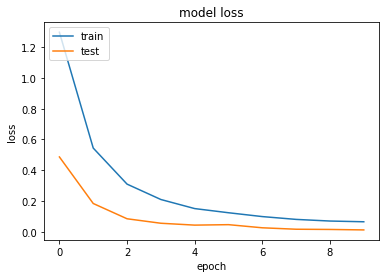

In [ ]:
%matplotlib inline

# summarize history for loss
plt.plot(eff_net_hist.history['loss'])
plt.plot(eff_net_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

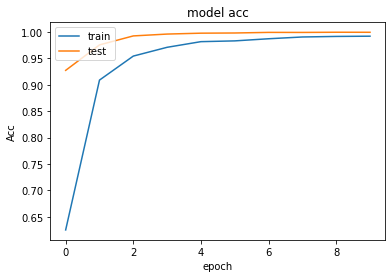

In [ ]:
%matplotlib inline
# summarize history for Accuracy
plt.plot(eff_net_hist.history['acc'])
plt.plot(eff_net_hist.history['val_acc'])
plt.title('model acc')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

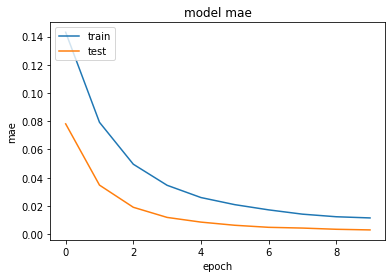

In [ ]:
%matplotlib inline
# summarize history for MAE
plt.plot(eff_net_hist.history['mae'])
plt.plot(eff_net_hist.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

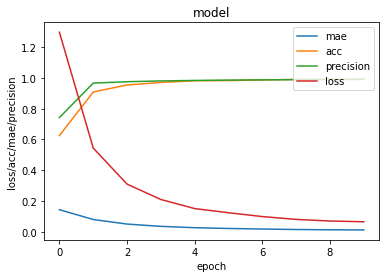

In [ ]:
%matplotlib inline
# summarize history for MAE
plt.plot(eff_net_hist.history['mae'])
plt.plot(eff_net_hist.history['acc'])
plt.plot(eff_net_hist.history['precision'])
plt.plot(eff_net_hist.history['loss'])
plt.title('model')
plt.ylabel('loss/acc/mae/precision')
plt.xlabel('epoch')
plt.legend(['mae','acc','precision','loss'], loc='upper right')
plt.show()

In [ ]:
# Validation
eff_net_score = ef_net.evaluate(np.array([patch_extractor2D(labeled_data,labels["Xline"][x],
                                                  labels["Time"][x],64,3) for x in test_samples]), 
                                                  keras.utils.to_categorical(labels["Class"][test_samples], num_classes=9))

39703/39703 [==============================] - 164s 4ms/step


In [ ]:
print(acc_assess(eff_net_score, loss_function, ["acc", "mae"]))

The test loss is 0.043
The test accuracy is 99.7%
The total mean error on the test is 0.008



In [ ]:
%matplotlib inline

patch_size = 64
t_max, y_max = xline_data.shape
half_patch = patch_size//2

eff_net_predx = np.full_like(xline_data,-1)
for space in tqdm_notebook(range(y_max),desc='Space'):
    for depth in tqdm_notebook(range(t_max),leave=False, desc='Time'):
        eff_net_predx[depth,space] = np.argmax(ef_net.predict(np.expand_dims(patch_extractor2D(xline_data,space,depth,patch_size,3), axis=0)))

np.save('eff_net_predi.npy', ef_net_predx, allow_pickle=False)
plt.imshow(eff_net_predx)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


NameError: ignored

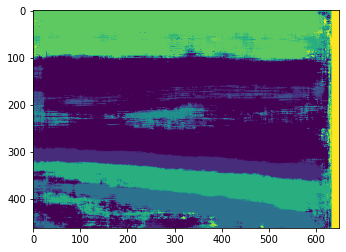

In [ ]:

np.save('eff_net_predx.npy', eff_net_predx, allow_pickle=False)
plt.imshow(eff_net_predx)

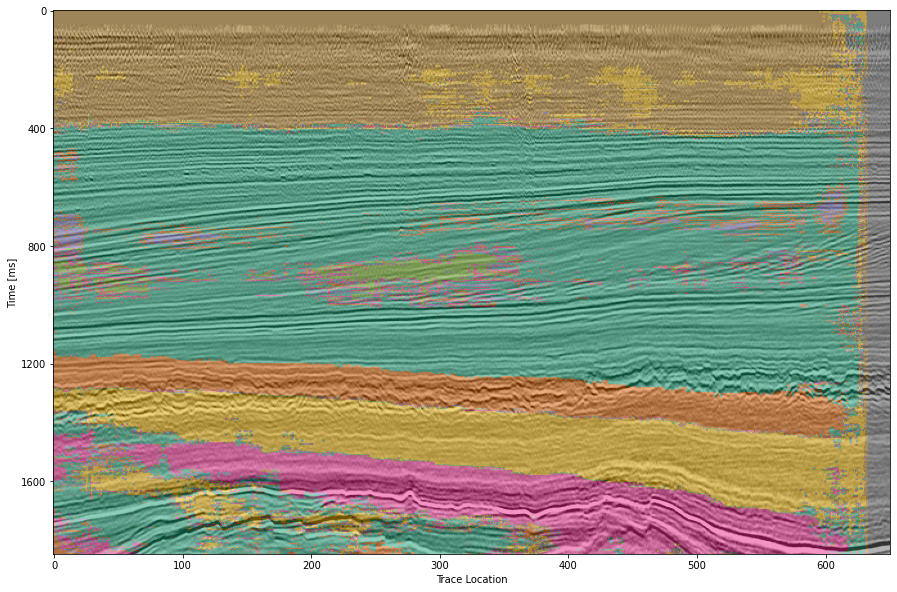

In [ ]:

eff_net_pred= np.load('eff_net_predx.npy')
fig2 = plt.figure(figsize=(15.0, 10.0))
img2 = plt.imshow(inline_data, cmap="Greys", vmin=-vmy, vmax=vmy, aspect='auto')
img1 = plt.imshow(eff_net_pred, aspect='auto', cmap="Dark2", alpha=0.5)
plt.yticks(np.arange(0, 462, 100), np.arange(0, 462*4, 400))
plt.xlabel('Trace Location')
plt.ylabel('Time [ms]')
plt.savefig('eff_x.png', bbox_inches='tight')
plt.show()

In [ ]:
 # for layer in ef_net.layers:
#     if isinstance(layer, BatchNormalization):
#         layer.trainable = True
#     else:
#         layer.trainable = False

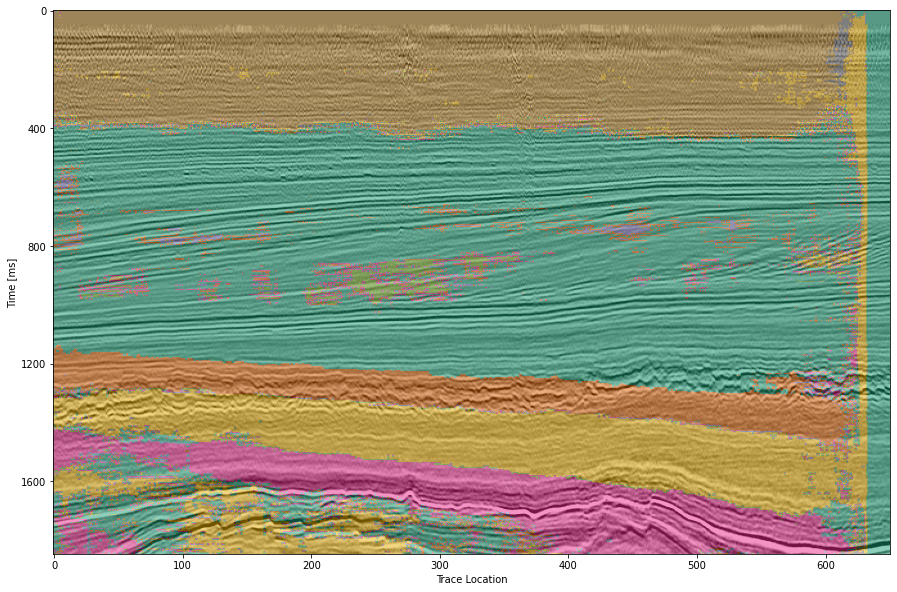

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

vmy = np.percentile(inline_data, 99)
eff_plt= np.load('/content/drive/My Drive/eff_net_predi.npy')

fig2 = plt.figure(figsize=(15.0, 10.0))
img2 = plt.imshow(inline_data, cmap="Greys", vmin=-vmy, vmax=vmy, aspect='auto')
img1 = plt.imshow(eff_plt, aspect='auto', cmap="Dark2", alpha=0.5)

plt.yticks(np.arange(0, 462, 100), np.arange(0, 462*4, 400))
plt.xlabel('Trace Location')
plt.ylabel('Time [ms]')
plt.savefig('eff_net_i.png', bbox_inches='tight')
plt.show()